In [1]:
import pandas as pd

df = pd.read_csv('data_with_extracted_skills_ONET_ESCO.csv')
df.head()

,job_id,job_title,company,descriptions,State,merged_category,category,subcategory,role_clean,type_clean,salary,clean_title+desc,extracted_skills_list
0,74630583,Procurement Executive (Contract),Coca-Cola Bottlers (Malaysia) Sdn Bhd,Position Purpose\nManage aspects of procuremen...,Negeri Sembilan,Manufacturing & Logistics,"Manufacturing, Transport & Logistics","Purchasing, Procurement & Inventory",Procurement Executive,Contract/Temp,NaN,procurement executive contract position purpos...,"['business laws', 'contract management', 'engl..."
1,74660602,Account Executive/ Assistant,Acoustic & Lighting System Sdn Bhd,We are looking for a Account Executive/ Assist...,Selangor,Accounting & Finance,Accounting,Bookkeeping & Small Practice Accounting,Executive Assistant,Full time,"RM 2,800 – RM 3,200 per month",account executive/ assistant we are looking fo...,"['balance', 'banking']"
2,74655679,"Data Analyst - Asset Management, SPX Express",Shopee Mobile Malaysia Sdn Bhd,Performs detailed data analysis on existing sp...,Selangor,Manufacturing & Logistics,"Manufacturing, Transport & Logistics",Analysis & Reporting,Asset Management Analyst,Full time,NaN,data analyst - asset management spx express pe...,"['asset management', 'data', 'data analysis', ..."
3,74657624,Service Engineer,Sun Medical Systems Sdn Bhd,"You are important for troubleshooting, install...",Selangor,Engineering & Technology,Engineering,Electrical/Electronic Engineering,Services Engineer,Full time,"RM 3,000 – RM 3,500 per month",service engineer you are important for trouble...,"['argument', 'biomedical engineering', 'cardio..."
4,74679363,Purchasing Executive,Magnet Security & Automation Sdn. Bhd.,"MAG is a trailblazer in the industry, boasting...",Selangor,Manufacturing & Logistics,"Manufacturing, Transport & Logistics","Purchasing, Procurement & Inventory",Purchasing Executive,Full time,"RM 2,800 – RM 3,500 per month",purchasing executive mag is a trailblazer in t...,"['analyze', 'communication', 'correspondence',..."


In [2]:
import pandas as pd
import ast

df = pd.read_csv('data_with_extracted_skills_full.csv')

# Fix the Data Type
#  use ast.literal_eval to safely convert these strings back into Python list objects.
df['extracted_skills_list'] = df['extracted_skills_list'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) and x.strip().startswith('[') else x
)
print("Data type conversion successful.")


# Recalculate Statistics 
total_rows = len(df)

# Check if the length of the list (now a true list object) is > 0
matched_cases_count = df['extracted_skills_list'].apply(lambda x: len(x) > 0).sum()

# Calculate percentage
matched_percentage = (matched_cases_count / total_rows) * 100

print("\n--- Final, Corrected Skill Matching Statistics ---")
print(f"Total documents processed: {total_rows}")
print(f"Documents with matched skills (non-empty list): {matched_cases_count}")
print(f"Percentage of matched documents: {matched_percentage:.2f}%")

Data type conversion successful.

--- Final, Corrected Skill Matching Statistics ---
Total documents processed: 65314
Documents with matched skills (non-empty list): 64495
Percentage of matched documents: 98.75%


In [3]:
# convert 'extracted_skills_list' column back to an actual list object for Gensim/LDA to work.
import ast
df['extracted_skills_list'] = df['extracted_skills_list'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

In [4]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.phrases import Phrases, Phraser
from gensim.models.ldamulticore import LdaMulticore
import time
import warnings
warnings.filterwarnings("ignore") # Suppress warnings during training

LDA_SAMPLE_SIZE = 7000  
RANDOM_SEED = 42

# list of all unique categories
target_categories = df['merged_category'].unique()

# Dictionary to store the trained model for each category
lda_models_by_category = {}

print(f"Starting LDA preparation for {len(target_categories)} categories...")

for TARGET_CATEGORY in target_categories:
    print(f"Processing Category: {TARGET_CATEGORY}")

    # Filter, Sample, and Create Initial Corpus 
    df_category = df[df['merged_category'] == TARGET_CATEGORY].copy()

    if len(df_category) < 50: # Skip categories with too few docs
        print(f"Skipping {TARGET_CATEGORY}: Not enough data ({len(df_category)} docs).")
        continue

    # Randomly sample the Category DataFrame (ensure sample size doesn't exceed category size)
    n_sample = min(LDA_SAMPLE_SIZE, len(df_category))
    df_category_sample = df_category.sample(
        n=n_sample,
        random_state=RANDOM_SEED
    ).copy()

    # Filter out job postings where no skills were found
    df_skill_corpus = df_category_sample[
        df_category_sample['extracted_skills_list'].apply(lambda x: len(x) > 0)
    ]
    skill_corpus_category = df_skill_corpus['extracted_skills_list'].tolist()

    if not skill_corpus_category:
        print(f"Skipping {TARGET_CATEGORY}: No documents remaining after skill filter.")
        continue
    
    print(f"Corpus size: {len(skill_corpus_category)} documents.")

Starting LDA preparation for 14 categories...
Processing Category: Manufacturing & Logistics
Corpus size: 5124 documents.
Processing Category: Accounting & Finance
Corpus size: 6907 documents.
Processing Category: Engineering & Technology
Corpus size: 6939 documents.
Processing Category: Administration
Corpus size: 6562 documents.
Processing Category: Human Resources
Corpus size: 3804 documents.
Processing Category: Sales & Marketing
Corpus size: 6931 documents.
Processing Category: Construction & Trades
Corpus size: 2782 documents.
Processing Category: Management & Strategy
Corpus size: 411 documents.
Processing Category: Creative & Design
Corpus size: 1219 documents.
Processing Category: Hospitality & Services
Corpus size: 3926 documents.
Processing Category: Education
Corpus size: 748 documents.
Processing Category: Social & Community / Other
Corpus size: 440 documents.
Processing Category: Healthcare
Corpus size: 849 documents.
Processing Category: Legal & Compliance
Corpus size: 3

In [5]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.phrases import Phrases, Phraser
from gensim.models.ldamulticore import LdaMulticore
import time, warnings
warnings.filterwarnings("ignore")

LDA_SAMPLE_SIZE = 7000
RANDOM_SEED = 42

target_categories = df['merged_category'].unique()

lda_models_by_category = {}

print(f"Starting LDA preparation for {len(target_categories)} categories...")

# Main Category Loop
for TARGET_CATEGORY in target_categories:
    print(f"\n=== Processing Category: {TARGET_CATEGORY} ===")

    # Filter & sample
    df_category = df[df['merged_category'] == TARGET_CATEGORY].copy()
    if len(df_category) < 50:
        print(f"Skipping {TARGET_CATEGORY}: Not enough data ({len(df_category)} docs).")
        continue

    n_sample = min(LDA_SAMPLE_SIZE, len(df_category))
    df_category_sample = df_category.sample(n=n_sample, random_state=RANDOM_SEED).copy()

    # Keep rows with non-empty extracted skills
    df_skill_corpus = df_category_sample[
        df_category_sample['extracted_skills_list'].apply(lambda x: isinstance(x, list) and len(x) > 0)
    ]
    skill_corpus_category = df_skill_corpus['extracted_skills_list'].tolist()

    if not skill_corpus_category:
        print(f"Skipping {TARGET_CATEGORY}: No documents remaining after skill filter.")
        continue

    print(f"Corpus size: {len(skill_corpus_category)} documents.")

    # Bigrams
    t0 = time.time()
    bigram = Phrases(skill_corpus_category, min_count=5, threshold=10)
    bigram_phraser = Phraser(bigram)
    skill_corpus_category_bigrams = [bigram_phraser[doc] for doc in skill_corpus_category]
    print(f"[{TARGET_CATEGORY}] Bigrams built in {time.time() - t0:.2f}s")

    # Dictionary & BoW
    dictionary_category = Dictionary(skill_corpus_category_bigrams)
    dictionary_category.filter_extremes(no_below=5, no_above=0.5)
    bow_corpus_category = [dictionary_category.doc2bow(doc) for doc in skill_corpus_category_bigrams]

    print(f"[{TARGET_CATEGORY}] vocab={len(dictionary_category)} | docs={len(bow_corpus_category)}")

    # Choose K safely
    K = 5
    if len(dictionary_category) < K:
        K = len(dictionary_category)
    if K < 2:
        print(f"Skipping {TARGET_CATEGORY}: Dictionary too small for LDA (K={K}).")
        continue

    # Train LDA
    lda_model = LdaMulticore(
        bow_corpus_category,
        num_topics=K,
        id2word=dictionary_category,
        passes=30,
        workers=4,
        random_state=RANDOM_SEED
    )
    lda_models_by_category[TARGET_CATEGORY] = lda_model

    print(f"[{TARGET_CATEGORY}] LDA trained with {K} topics.")
    print(f"--- Topics for {TARGET_CATEGORY} (K={K}) ---")
    for tid, terms in lda_model.print_topics():
        print(f"  {tid}: {terms}")

Starting LDA preparation for 14 categories...

=== Processing Category: Manufacturing & Logistics ===
Corpus size: 5124 documents.
[Manufacturing & Logistics] Bigrams built in 0.25s
[Manufacturing & Logistics] vocab=691 | docs=5124
[Manufacturing & Logistics] LDA trained with 5 topics.
--- Topics for Manufacturing & Logistics (K=5) ---
  0: 0.077*"english" + 0.066*"communication" + 0.055*"logistics" + 0.042*"warehouse" + 0.041*"language" + 0.032*"computer" + 0.031*"purchase" + 0.030*"work independently" + 0.028*"customer service" + 0.027*"report"
  1: 0.060*"communication" + 0.045*"plan" + 0.040*"schedule" + 0.039*"supply chain management" + 0.038*"purchase" + 0.037*"negotiation" + 0.037*"lead" + 0.035*"logistics" + 0.033*"data" + 0.029*"processes"
  2: 0.061*"engineering" + 0.042*"communication" + 0.040*"equipment" + 0.039*"processes" + 0.033*"lead" + 0.026*"reporting" + 0.026*"report" + 0.022*"data" + 0.021*"conduct" + 0.020*"plan"
  3: 0.059*"report" + 0.056*"reporting" + 0.044*"pur

In [6]:
import pandas as pd
from gensim.corpora.dictionary import Dictionary
from gensim.models.phrases import Phrases, Phraser
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
import warnings
import time

# Suppress minor Gensim/Pandas warnings during training
warnings.filterwarnings("ignore") 

# DEFINE UTILITY FUNCTIONS

def calculate_diversity_score(lda_model, top_words_to_check=10):
    """Calculates Topic Diversity (TD) for a given LDA model."""
    topic_words = []
    for topic_id in range(lda_model.num_topics):
        words = [word for word, prob in lda_model.show_topic(topic_id, topn=top_words_to_check)]
        topic_words.append(set(words))
    
    unique_words = set.union(*topic_words)
    diversity_score = len(unique_words) / (lda_model.num_topics * top_words_to_check)
    return diversity_score

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence and diversity for various number of topics (K).
    Returns the optimal K and its scores.
    """
    best_k = start
    max_coherence = -1
    best_diversity = 0
    passes_for_tuning = 10 # Use 10 passes for faster tuning
    
    print(f"Checking K from {start} to {limit-1} (Passes={passes_for_tuning})...")
    
    for num_topics in range(start, limit, step):
        # Train the LDA model
        model = LdaMulticore(
            corpus=corpus, 
            num_topics=num_topics, 
            id2word=dictionary, 
            passes=passes_for_tuning, 
            alpha='asymmetric',  
            eta='symmetric',     
            workers=4,
            random_state=42
        )
        
        # 2. Calculate the coherence score
        coherencemodel = CoherenceModel(
            model=model, texts=texts, dictionary=dictionary, coherence='c_v'
        )
        coherence_score = coherencemodel.get_coherence()

        # 3. Calculate the diversity score
        diversity_score = calculate_diversity_score(model)

        print(f"K={num_topics} | Coherence: {coherence_score:.4f} | Diversity: {diversity_score:.4f}")
        
        # 4. Track the best K based on max coherence
        if coherence_score > max_coherence:
            max_coherence = coherence_score
            best_k = num_topics
            best_diversity = diversity_score

    return best_k, max_coherence, best_diversity

# CONFIGURATION & LOOP SETUP

LDA_SAMPLE_SIZE = 15000 
RANDOM_SEED = 42
K_MIN = 2
K_MAX = 11 # Check up to K=10 topics for tuning
STEP = 1
MIN_DICT_SIZE = 10 # Skip categories with too few skills

final_results = []
target_categories = df['merged_category'].unique()

# MAIN LOOP: Integration of Preparation and Tuning 

for TARGET_CATEGORY in target_categories:
    print(f"\n=======================================================")
    print(f"🚀 STARTING OPTIMIZATION FOR: {TARGET_CATEGORY}")
    print(f"=======================================================")
    
    # Filter, Sample, and Create Initial Corpus 
    df_category = df[df['merged_category'] == TARGET_CATEGORY].copy()
    
    if len(df_category) < 100:
        print(f"Skipping {TARGET_CATEGORY}: Not enough data ({len(df_category)} docs).")
        continue

    n_sample = min(LDA_SAMPLE_SIZE, len(df_category))
    df_category_sample = df_category.sample(n=n_sample, random_state=RANDOM_SEED).copy()

    df_skill_corpus = df_category_sample[
        df_category_sample['extracted_skills_list'].apply(lambda x: isinstance(x, list) and len(x) > 0)
    ]
    skill_corpus_category = df_skill_corpus['extracted_skills_list'].tolist()

    if not skill_corpus_category:
        print(f"Skipping {TARGET_CATEGORY}: No documents remaining after skill filter.")
        continue

    # Bigram Modeling
    bigram = Phrases(skill_corpus_category, min_count=5, threshold=10)
    bigram_phraser = Phraser(bigram)
    skill_corpus_category_bigrams = [
        bigram_phraser[doc] for doc in skill_corpus_category
    ]

    # Dictionary and BoW Corpus
    dictionary_category = Dictionary(skill_corpus_category_bigrams)
    dictionary_category.filter_extremes(no_below=10, no_above=0.5) 

    if len(dictionary_category) < MIN_DICT_SIZE:
        print(f"Skipping {TARGET_CATEGORY}: Dictionary size too small ({len(dictionary_category)}).")
        continue

    bow_corpus_category = [
        dictionary_category.doc2bow(doc) for doc in skill_corpus_category_bigrams
    ]
    
    print(f"Corpus size: {len(bow_corpus_category)} | Dictionary size: {len(dictionary_category)}")

    # Run the full Coherence and Diversity optimization loop
    best_k, max_coherence, best_diversity = compute_coherence_values(
        dictionary=dictionary_category, 
        corpus=bow_corpus_category, 
        texts=skill_corpus_category_bigrams, 
        start=K_MIN, 
        limit=K_MAX, 
        step=STEP
    )
    
    # Store the results
    final_results.append({
        'Category': TARGET_CATEGORY,
        'Optimal K': best_k,
        'Max Coherence (cv)': max_coherence,
        'Diversity @ K': best_diversity,
        'Sample Size': len(df_category_sample)
    })

# Final Output

df_results = pd.DataFrame(final_results)
print("\n\n#######################################################")
print("          LDA OPTIMIZATION RESULTS (ONETESCO)             ")
print("#######################################################")
print(df_results)

# Save results to CSV for reporting
df_results.to_csv('lda_optimization_results_ONETESCO_by_sector.csv', index=False)


🚀 STARTING OPTIMIZATION FOR: Manufacturing & Logistics
Corpus size: 5124 | Dictionary size: 422
Checking K from 2 to 10 (Passes=10)...
K=2 | Coherence: 0.4064 | Diversity: 0.7000
K=3 | Coherence: 0.4093 | Diversity: 0.6667
K=4 | Coherence: 0.4523 | Diversity: 0.6250
K=5 | Coherence: 0.4451 | Diversity: 0.6000
K=6 | Coherence: 0.4420 | Diversity: 0.5000
K=7 | Coherence: 0.4685 | Diversity: 0.4857
K=8 | Coherence: 0.4617 | Diversity: 0.4375
K=9 | Coherence: 0.4554 | Diversity: 0.4000
K=10 | Coherence: 0.4588 | Diversity: 0.3600

🚀 STARTING OPTIMIZATION FOR: Accounting & Finance
Corpus size: 12889 | Dictionary size: 592
Checking K from 2 to 10 (Passes=10)...
K=2 | Coherence: 0.4826 | Diversity: 0.8500
K=3 | Coherence: 0.4931 | Diversity: 0.6667
K=4 | Coherence: 0.4728 | Diversity: 0.5750
K=5 | Coherence: 0.4587 | Diversity: 0.5600
K=6 | Coherence: 0.4693 | Diversity: 0.5333
K=7 | Coherence: 0.4350 | Diversity: 0.4429
K=8 | Coherence: 0.4516 | Diversity: 0.4875
K=9 | Coherence: 0.4470 | D

# Full Corpus training

In [7]:
import pandas as pd
from gensim.corpora.dictionary import Dictionary
from gensim.models.phrases import Phrases, Phraser
from gensim.models.ldamulticore import LdaMulticore
import os
import ast
import warnings
warnings.filterwarnings("ignore")

# CONFIGURATION & FILE NAMES 
EXTRACTED_SKILLS_FILE = 'data_with_extracted_skills_ONET_ESCO.csv'
LDA_OPTIMIZATION_FILE = 'lda_optimization_results_ONETESCO_by_sector.csv'
RANDOM_SEED = 42
FINAL_PASSES = 30 # Use higher passes for the final model
NUM_CORES = os.cpu_count()
OPTIMIZED_WORKERS = max(1, NUM_CORES - 1) 
TOP_N_WORDS = 10

# LOAD DATA AND OPTIMAL K VALUES
try:
    df = pd.read_csv(EXTRACTED_SKILLS_FILE)
    # Convert string representation of list back to list object
    df['extracted_skills_list'] = df['extracted_skills_list'].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else x
    )
    print(f"Loaded {len(df)} documents from '{EXTRACTED_SKILLS_FILE}'.")
except FileNotFoundError:
    print(f"FATAL ERROR: Extracted skills file '{EXTRACTED_SKILLS_FILE}' not found.")
    raise

try:
    # Load the Optimal K values from optimization run
    df_optimal_k = pd.read_csv(LDA_OPTIMIZATION_FILE)
    print(f"Optimal K values loaded from '{LDA_OPTIMIZATION_FILE}'.")
except FileNotFoundError:
    print(f"FATAL ERROR: Optimal K results file '{LDA_OPTIMIZATION_FILE}' not found. Cannot proceed without it.")
    raise # Stop execution

# MAIN LOOP FOR FINAL TRAINING AND TOPIC EXTRACTION

all_topics_data = [] # List to store all topic results
print(f"\nTraining final models (Passes={FINAL_PASSES}, Workers={OPTIMIZED_WORKERS}) and extracting topics...")

for index, row in df_optimal_k.iterrows():
    TARGET_CATEGORY = row['Category']
    K_FINAL = int(row['Optimal K'])
    
    print(f"\n--- Training Final Model: {TARGET_CATEGORY} (K={K_FINAL}) ---")

    # Filter the entire df for the chosen category
    df_category_full = df[df['merged_category'] == TARGET_CATEGORY].copy()

    # Keep ALL relevant documents (no sampling)
    df_skill_corpus_full = df_category_full[
        df_category_full['extracted_skills_list'].apply(lambda x: isinstance(x, list) and len(x) > 0)
    ]
    skill_corpus_full = df_skill_corpus_full['extracted_skills_list'].tolist()

    if len(skill_corpus_full) < 100 or K_FINAL < 2: # Skip small or trivial categories
        print(f"Skipping final model due to small corpus size ({len(skill_corpus_full)} documents) or K<2.")
        continue

    # Re-run Bigrams on FULL CORPUS (Replicate feature engineering from tuning)
    bigram = Phrases(skill_corpus_full, min_count=5, threshold=10)
    bigram_phraser = Phraser(bigram)
    skill_corpus_bigrams_full = [bigram_phraser[doc] for doc in skill_corpus_full]

    # Re-create Dictionary and BoW on FULL CORPUS
    dictionary_category = Dictionary(skill_corpus_bigrams_full)
    # MUST use the same filtering: no_below=10 (or whatever was used during K-tuning)
    dictionary_category.filter_extremes(no_below=10, no_above=0.5) 
    bow_corpus_full = [dictionary_category.doc2bow(doc) for doc in skill_corpus_bigrams_full]

    # Train the Final LDA Model
    lda_model_final = LdaMulticore(
        corpus=bow_corpus_full,
        num_topics=K_FINAL,
        id2word=dictionary_category,
        passes=FINAL_PASSES,
        alpha='asymmetric',
        eta='symmetric',
        workers=OPTIMIZED_WORKERS,
        random_state=RANDOM_SEED
    )

    # Extract Topics and Store Results
    for topic_id in range(K_FINAL):
        top_terms = lda_model_final.show_topic(topic_id, topn=TOP_N_WORDS)
        
        # Create a single string of weighted terms for easy reporting
        term_string = ' + '.join([f"{prob:.3f}*\"{word}\"" for word, prob in top_terms])

        all_topics_data.append({
            'Category': TARGET_CATEGORY,
            'Optimal_K': K_FINAL,
            'Topic_ID': topic_id,
            'Topic_Words': term_string,
        })
        
    print(f"Extraction complete. Extracted {K_FINAL} topics.")


#  FINAL TOPIC OUTPUT 
df_final_topics = pd.DataFrame(all_topics_data)

print("\n\n#######################################################")
print("        FINAL LDA TOPICS BY SECTOR (ONETESCO)          ")
print("#######################################################")
print(df_final_topics.head(20).to_markdown(index=False))

# Save the final topics table
df_final_topics.to_csv('final_lda_topics_ONETESCO_by_sector.csv', index=False)
print("\nFinal topics saved to 'final_lda_topics_ONETESCO_by_sector.csv'.")


Training final models (Passes=30, Workers=15) and extracting topics...

--- Training Final Model: Manufacturing & Logistics (K=6) ---
Extraction complete. Extracted 6 topics.

--- Training Final Model: Accounting & Finance (K=10) ---
Extraction complete. Extracted 10 topics.

--- Training Final Model: Engineering & Technology (K=8) ---
Extraction complete. Extracted 8 topics.

--- Training Final Model: Administration (K=7) ---
Extraction complete. Extracted 7 topics.

--- Training Final Model: Human Resources (K=5) ---
Extraction complete. Extracted 5 topics.

--- Training Final Model: Sales & Marketing (K=9) ---
Extraction complete. Extracted 9 topics.

--- Training Final Model: Construction & Trades (K=6) ---
Extraction complete. Extracted 6 topics.

--- Training Final Model: Management & Strategy (K=2) ---
Extraction complete. Extracted 2 topics.

--- Training Final Model: Creative & Design (K=3) ---
Extraction complete. Extracted 3 topics.

--- Training Final Model: Hospitality & 

In [8]:
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
import pandas as pd
import numpy as np

# Define Utility Functions

def calculate_diversity_score(lda_model, top_words_to_check=10):
    """Calculates Topic Diversity (TD) for a given LDA model."""
    topic_words = []
    for topic_id in range(lda_model.num_topics):
        words = [word for word, prob in lda_model.show_topic(topic_id, topn=top_words_to_check)]
        topic_words.append(set(words))
    
    unique_words = set.union(*topic_words)
    diversity_score = len(unique_words) / (lda_model.num_topics * top_words_to_check)
    return diversity_score

def calculate_coherence(lda_model, texts, dictionary):
    """Calculates the C_v Coherence score."""
    coherencemodel = CoherenceModel(
        model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v'
    )
    return coherencemodel.get_coherence()

# Initialize Final Score List
# This list will store the final K, Coherence, and Diversity for all categories
final_score_metrics = [] 

# TRAIN AND CALCULATE 
print("\n--- Starting Final Coherence & Diversity Calculation ---")

# Ensure df_optimal_k is the DataFrame driving the loop
for index, row in df_optimal_k.iterrows():
    TARGET_CATEGORY = row['Category']
    K_FINAL = int(row['Optimal K'])
    
    # Filter full corpus 
    df_category_full = df[df['merged_category'] == TARGET_CATEGORY].copy()
    df_skill_corpus_full = df_category_full[
        df_category_full['extracted_skills_list'].apply(lambda x: isinstance(x, list) and len(x) > 0)
    ]
    skill_corpus_full = df_skill_corpus_full['extracted_skills_list'].tolist()

    if len(skill_corpus_full) < 100 or K_FINAL < 2:
        continue

    # Re-run Bigrams on FULL CORPUS
    bigram = Phrases(skill_corpus_full, min_count=5, threshold=10)
    bigram_phraser = Phraser(bigram)
    skill_corpus_bigrams_full = [bigram_phraser[doc] for doc in skill_corpus_full]

    # Re-create Dictionary and BoW on FULL CORPUS (same filtering: no_below=10)
    dictionary_category = Dictionary(skill_corpus_bigrams_full)
    dictionary_category.filter_extremes(no_below=10, no_above=0.5) 
    bow_corpus_full = [dictionary_category.doc2bow(doc) for doc in skill_corpus_bigrams_full]
    
    # Check if K_FINAL is still valid after filtering
    if K_FINAL > len(dictionary_category):
        K_FINAL = len(dictionary_category)
        if K_FINAL < 2: continue

    # Train the FINAL Model 
    lda_model_final = LdaMulticore(
        corpus=bow_corpus_full,
        num_topics=K_FINAL,
        id2word=dictionary_category,
        passes=FINAL_PASSES,
        alpha='asymmetric',
        eta='symmetric',
        workers=OPTIMIZED_WORKERS,
        random_state=RANDOM_SEED
    )

    # Calculate Final Coherence and Diversity Scores
    coherence_final = calculate_coherence(lda_model_final, skill_corpus_bigrams_full, dictionary_category)
    diversity_final = calculate_diversity_score(lda_model_final)

    # Store Results
    final_score_metrics.append({
        'Category': TARGET_CATEGORY,
        'Optimal K': K_FINAL,
        'Coherence (Full Corpus)': coherence_final,
        'Diversity (Full Corpus)': diversity_final
    })
    
    print(f"Calculated: {TARGET_CATEGORY} | Coherence: {coherence_final:.4f} | Diversity: {diversity_final:.4f}")

# Final Output
df_final_scores = pd.DataFrame(final_score_metrics)

print("\n\n#######################################################")
print("  FINAL COHERENCE & DIVERSITY METRICS (FULL CORPUS)  ")
print("#######################################################")
print(df_final_scores.to_markdown(index=False))

# Save the final metrics table
df_final_scores.to_csv('final_lda_coherence_metrics_full_ONETESCO.csv', index=False)


--- Starting Final Coherence & Diversity Calculation ---
Calculated: Manufacturing & Logistics | Coherence: 0.4366 | Diversity: 0.5500
Calculated: Accounting & Finance | Coherence: 0.4695 | Diversity: 0.4200
Calculated: Engineering & Technology | Coherence: 0.4604 | Diversity: 0.4500
Calculated: Administration | Coherence: 0.4218 | Diversity: 0.6000
Calculated: Human Resources | Coherence: 0.4349 | Diversity: 0.5800
Calculated: Sales & Marketing | Coherence: 0.4231 | Diversity: 0.5000
Calculated: Construction & Trades | Coherence: 0.4455 | Diversity: 0.6500
Calculated: Management & Strategy | Coherence: 0.3160 | Diversity: 0.7500
Calculated: Creative & Design | Coherence: 0.3946 | Diversity: 0.8000
Calculated: Hospitality & Services | Coherence: 0.4295 | Diversity: 0.7250
Calculated: Education | Coherence: 0.3541 | Diversity: 0.6400
Calculated: Social & Community / Other | Coherence: 0.2804 | Diversity: 0.5400
Calculated: Healthcare | Coherence: 0.3675 | Diversity: 0.8500


##########

# Charts and Illustrations

Generating 13 Coherence-Only Plots...
all_sector_coherence_curves_ONETESCO.png


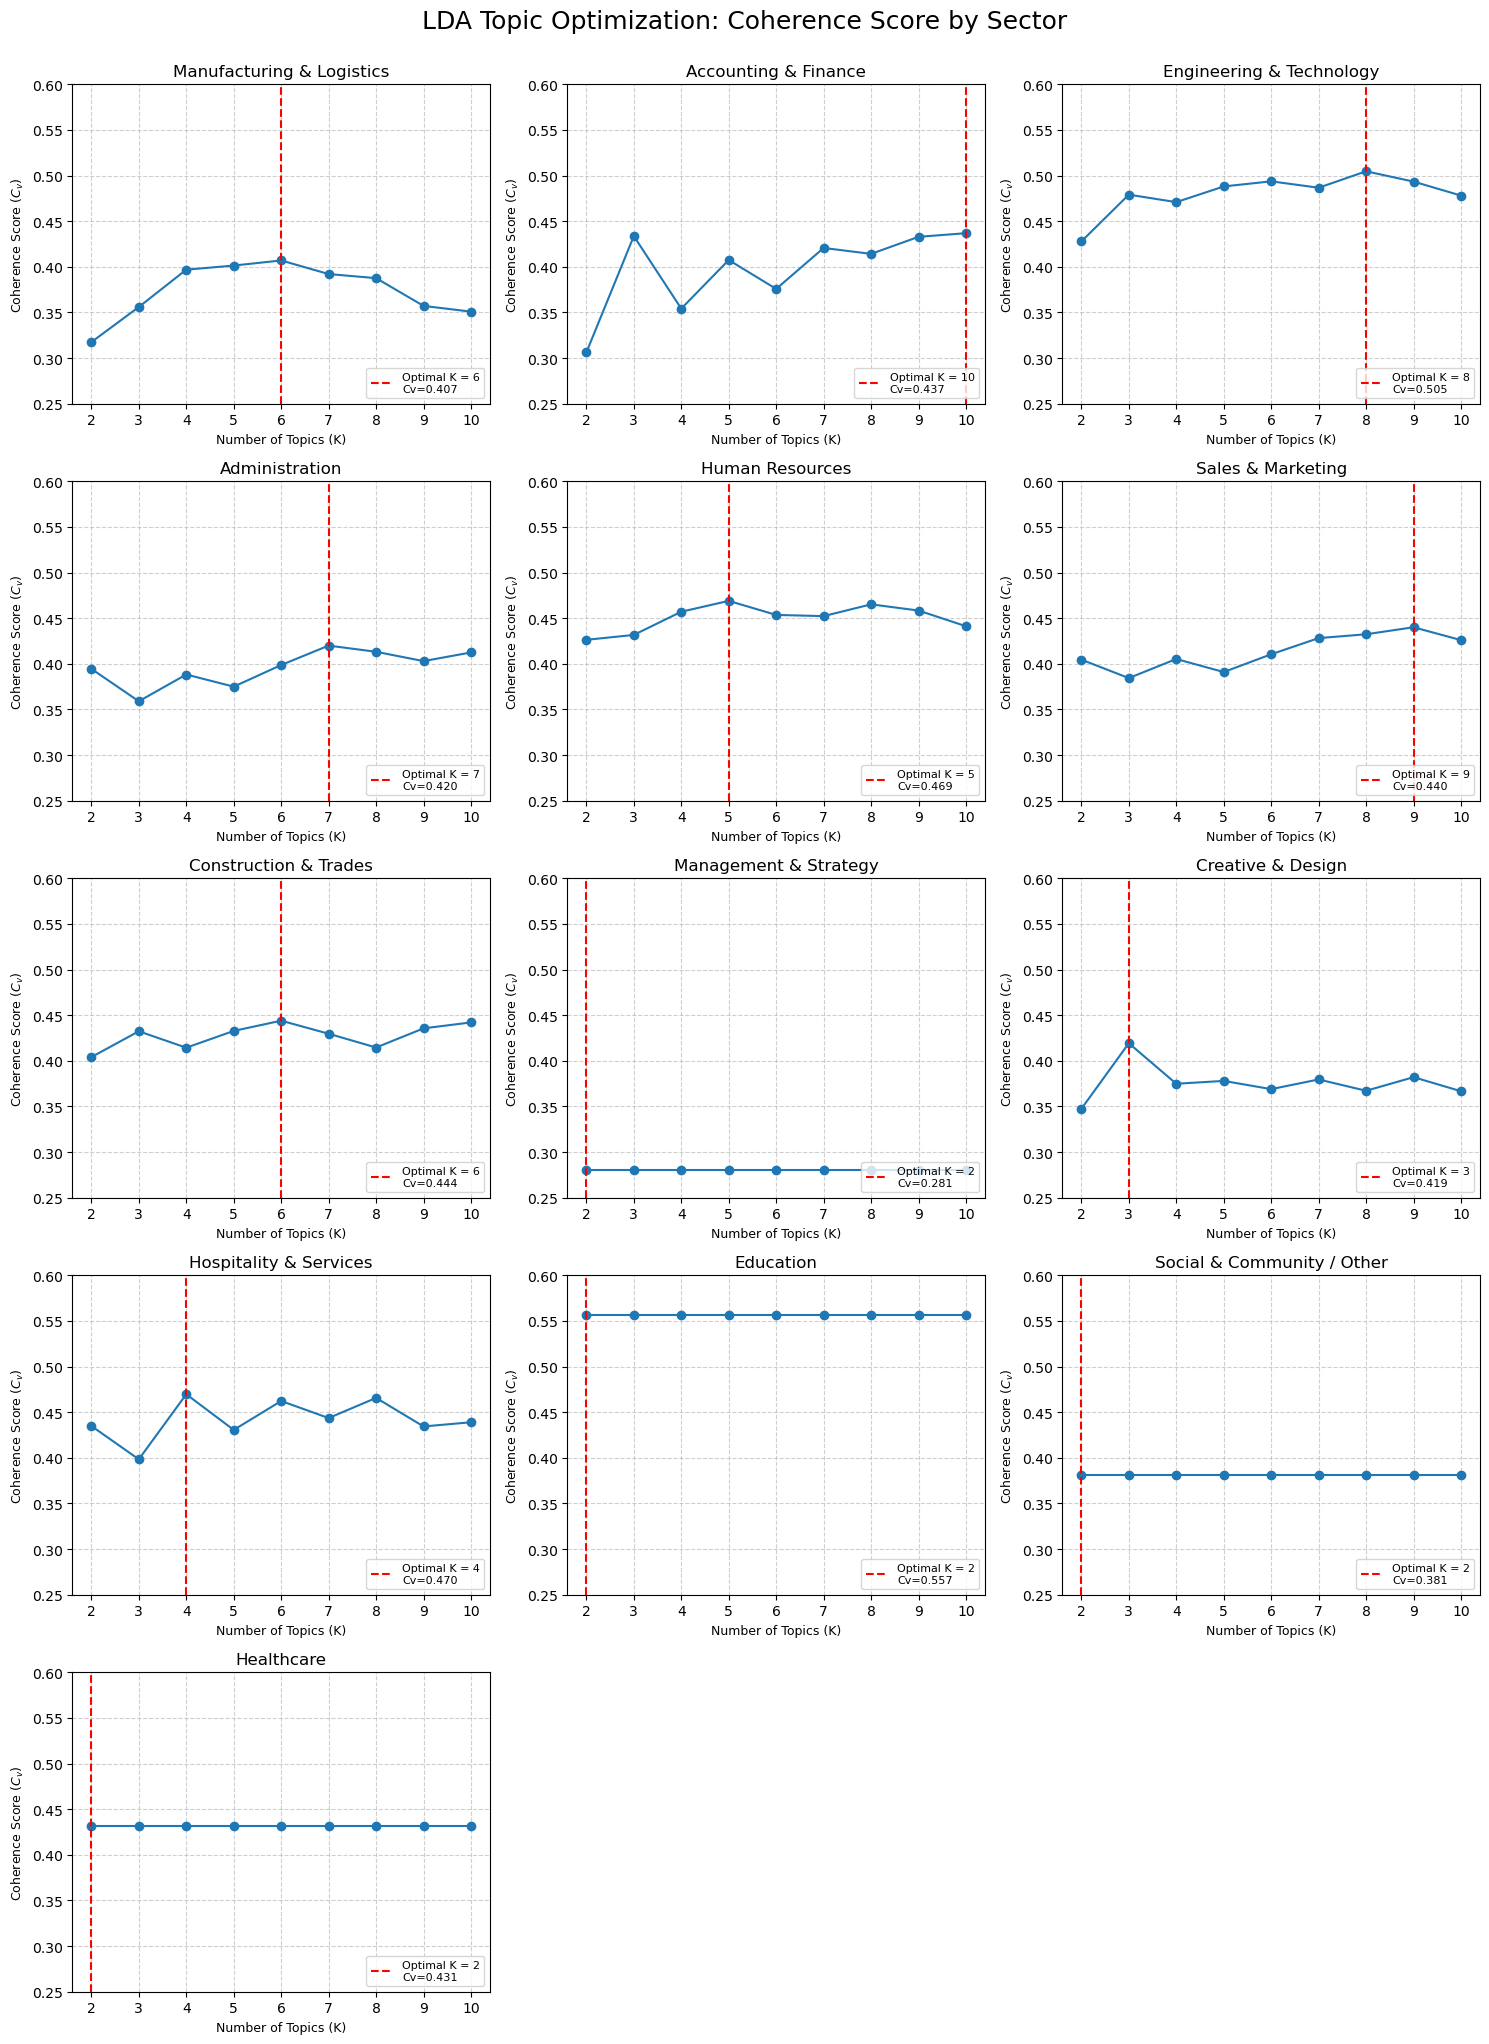

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# CONFIGURATION
COHERENCE_CURVES_FILE = 'coherence_curves_full.csv' 
COHERENCE_Y_MIN = 0.25 # Set y-axis bounds 
COHERENCE_Y_MAX = 0.60 

# LOAD AND PREPARE COHERENCE DATA 
try:
    df_coherence_data = pd.read_csv(COHERENCE_CURVES_FILE)
    
    coherence_data_by_category = {}
    
    # Dynamically identify columns containing coherence scores (e.g., 'K2', 'K3', ...)
    coherence_cols = [col for col in df_coherence_data.columns if col.startswith('K')]
    
    # Dynamically determine the K-values from the column names
    k_values = np.array([int(col[1:]) for col in coherence_cols])
    
    # Transform the DataFrame rows into the dictionary format needed for plotting
    for index, row in df_coherence_data.iterrows():
        category = row['Category']
        coherence_curve = row[coherence_cols].values
        coherence_data_by_category[category] = coherence_curve

except FileNotFoundError:
    print(f"FATAL ERROR: Coherence data file '{COHERENCE_CURVES_FILE}' not found.")
    print("Please ensure your K-optimization step ran and saved the results correctly.")
    raise # Stop execution

# LOOP AND PLOT
NUM_CATEGORIES = len(coherence_data_by_category)
ROWS = int(np.ceil(NUM_CATEGORIES / 3)) # Plot 3 charts per row
COLS = 3

fig, axes = plt.subplots(ROWS, COLS, figsize=(15, 4 * ROWS))
axes = axes.flatten()

print(f"Generating {NUM_CATEGORIES} Coherence-Only Plots...")

for i, (category, coherence_curve) in enumerate(coherence_data_by_category.items()):
    ax = axes[i]
    
    # Calculate Optimal K
    optimal_k_index = np.argmax(coherence_curve)
    optimal_k = k_values[optimal_k_index]
    max_coherence = coherence_curve[optimal_k_index]
    
    # Plot the Coherence Curve
    ax.plot(k_values, coherence_curve, marker='o', color='tab:blue')
    
    # Highlight Optimal K
    ax.axvline(x=optimal_k, color='r', linestyle='--', 
               label=f'Optimal K = {optimal_k}\n$C_v={max_coherence:.3f}$')
    
    # Set Labels and Title
    ax.set_title(f'{category}', fontsize=12)
    ax.set_xlabel("Number of Topics (K)", fontsize=9)
    ax.set_ylabel("Coherence Score ($C_v$)", fontsize=9)
    ax.set_ylim(COHERENCE_Y_MIN, COHERENCE_Y_MAX)
    ax.set_xticks(k_values)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(loc='lower right', fontsize=8)

# Turn off any unused subplots
for i in range(NUM_CATEGORIES, len(axes)):
    axes[i].axis('off')

# Finalize and Save
fig.tight_layout()
fig.suptitle('LDA Topic Optimization: Coherence Score by Sector (O*NET + ESCO)', fontsize=18, y=1.02)
plt.savefig('all_sector_coherence_curves_ONETESCO.png')
print("all_sector_coherence_curves_ONETESCO.png")


--- Generating 13 Word Clouds (Best Topic Snapshot) ---

Word cloud summary visualization saved as 'all_merged_sector_best_topic_ONETESCO.png'.


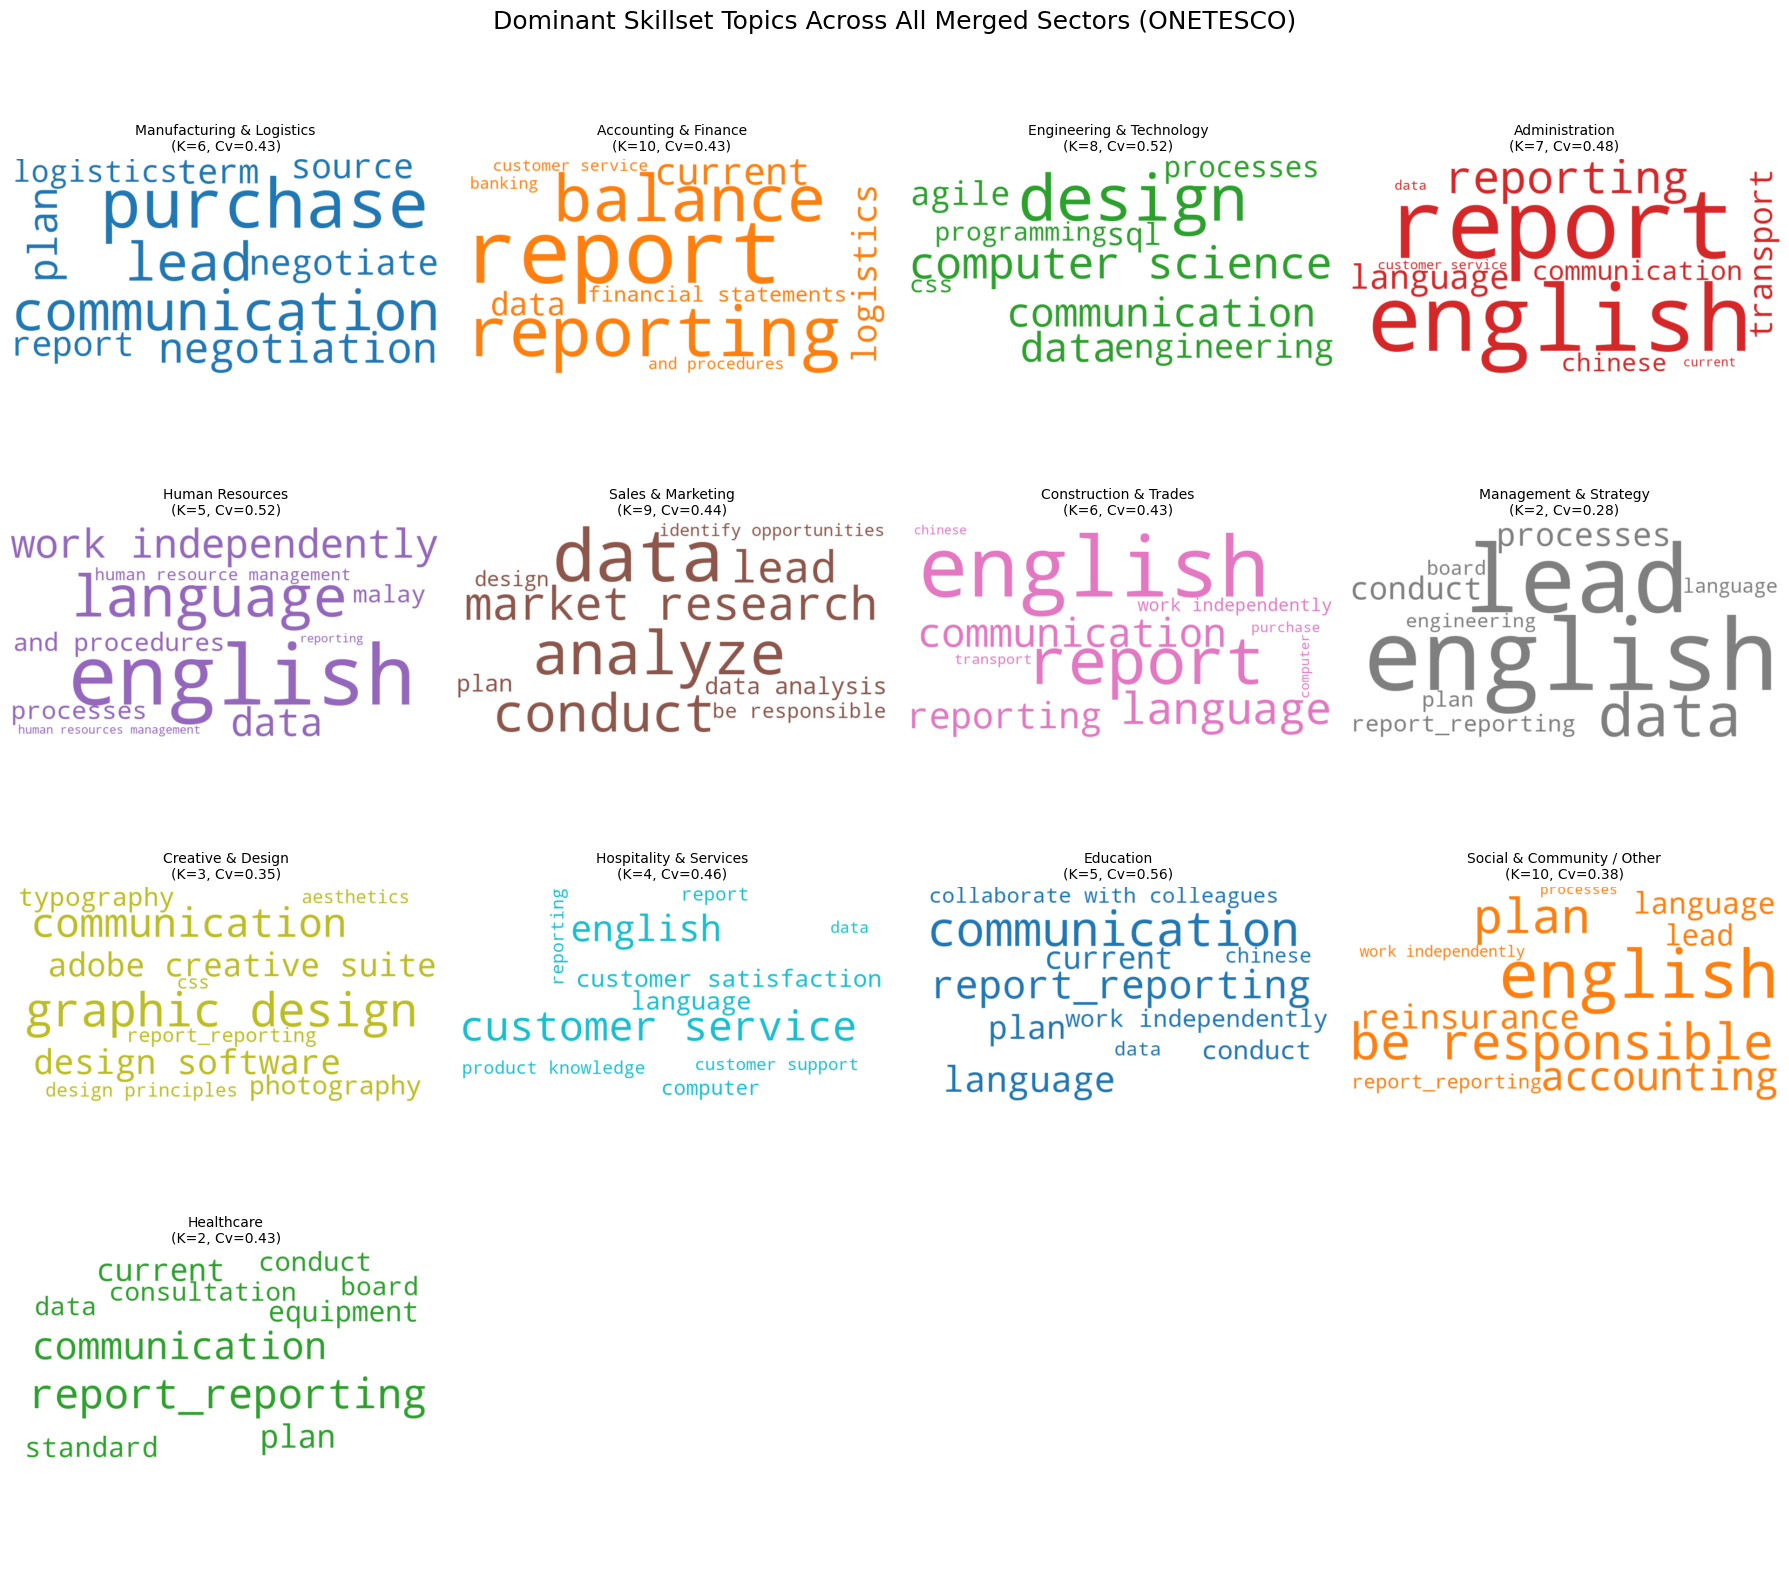

In [11]:
import pandas as pd
from collections import Counter
from gensim.corpora.dictionary import Dictionary
from gensim.models.phrases import Phrases, Phraser
from gensim.models.ldamulticore import LdaMulticore
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
import numpy as np
import warnings
import ast # Need to import ast for literal_eval

warnings.filterwarnings("ignore")

# CONFIGURATION & FILE NAMES 
EXTRACTED_SKILLS_FILE = 'data_with_extracted_skills_ONET_ESCO.csv'
LDA_OPTIMIZATION_FILE = 'lda_optimization_results_ONETESCO_by_sector.csv'
RANDOM_SEED = 42
FINAL_PASSES = 30
OPTIMIZED_WORKERS = max(1, os.cpu_count() - 1)
MIN_DICT_BELOW = 10 
TOPIC_TO_PLOT = 0 # Plot the first topic (usually the most dominant)

# LOAD DATA AND OPTIMAL K VALUES 

# Load main DataFrame (df)
try:
    df = pd.read_csv(EXTRACTED_SKILLS_FILE)
    # Convert string representation of list back to list object
    df['extracted_skills_list'] = df['extracted_skills_list'].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else x
    )
except FileNotFoundError:
    print(f"FATAL ERROR: Extracted skills file '{EXTRACTED_SKILLS_FILE}' not found.")
    raise

# Load Optimal K results 
try:
    df_optimal_k = pd.read_csv(LDA_OPTIMIZATION_FILE)
except FileNotFoundError:
    print(f"FATAL ERROR: Optimal K results file '{LDA_OPTIMIZATION_FILE}' not found. Cannot plot.")
    raise # Stop execution

# SETUP PLOT
NUM_CATEGORIES = len(df_optimal_k)
ROWS = int(np.ceil(NUM_CATEGORIES / 4))
COLS = 4

fig, axes = plt.subplots(ROWS, COLS, figsize=(18, 4 * ROWS))
axes = axes.flatten()
plot_index = 0
colors = [mcolors.to_rgb(color) for name, color in mcolors.TABLEAU_COLORS.items()]
print(f"\n--- Generating {NUM_CATEGORIES} Word Clouds (Best Topic Snapshot) ---")

# LOOP: TRAIN FINAL MODEL (K=Optimal K) and PLOT TOPIC 0 

for index, row in df_optimal_k.iterrows():
    TARGET_CATEGORY = row['Category']
    K_FINAL = int(row['Optimal K'])
    COHERENCE_CV = row['Max Coherence (cv)']
    
    if K_FINAL < 2:  # Skip categories with minimal data/poor tuning results
        print(f"Skipping {TARGET_CATEGORY} (K<2).")
        continue

    # Filter and Prepare Full Corpus (identical to final training)
    df_category_full = df[df['merged_category'] == TARGET_CATEGORY].copy()
    df_skill_corpus_full = df_category_full[
        df_category_full['extracted_skills_list'].apply(lambda x: isinstance(x, list) and len(x) > 0)
    ]
    skill_corpus_full = df_skill_corpus_full['extracted_skills_list'].tolist()
    
    if len(skill_corpus_full) < 100:
        continue

    # Bigrams & Dictionary (FULL CORPUS) - Replicate Feature Engineering
    bigram = Phrases(skill_corpus_full, min_count=5, threshold=10)
    bigram_phraser = Phraser(bigram)
    skill_corpus_bigrams_full = [bigram_phraser[doc] for doc in skill_corpus_full]

    dictionary_category = Dictionary(skill_corpus_bigrams_full)
    dictionary_category.filter_extremes(no_below=MIN_DICT_BELOW, no_above=0.5) 
    bow_corpus_full = [dictionary_category.doc2bow(doc) for doc in skill_corpus_bigrams_full]
    
    # Final check on K validity
    if K_FINAL > len(dictionary_category): K_FINAL = len(dictionary_category)
    if K_FINAL < 2: continue
    
    # Train the FINAL LDA Model
    lda_model_final = LdaMulticore(
        corpus=bow_corpus_full,
        num_topics=K_FINAL,
        id2word=dictionary_category,
        passes=FINAL_PASSES,
        workers=OPTIMIZED_WORKERS,
        random_state=RANDOM_SEED
    )

    # Extract Topic 0 (The Dominant Topic)
    ax = axes[plot_index]
    topics = lda_model_final.show_topics(num_words=10, formatted=False)
    topic_words = dict(topics[TOPIC_TO_PLOT][1]) 
    
    # Generate Word Cloud
    cloud = WordCloud(
        background_color='white', width=800, height=400, max_words=10,
        # Corrected color_func to use the current index's color
        color_func=lambda *args, **kwargs: mcolors.to_hex(colors[plot_index % len(colors)]),
        prefer_horizontal=0.9
    )
    cloud.generate_from_frequencies(topic_words)
    
    # Plotting
    ax.imshow(cloud, interpolation="bilinear")
    title = f"{TARGET_CATEGORY}\n(K={K_FINAL}, $C_v={COHERENCE_CV:.2f}$)"
    ax.set_title(title, fontsize=10)
    ax.axis('off')
    
    plot_index += 1

# Finalize Plot
for i in range(plot_index, len(axes)):
    axes[i].axis('off')

fig.suptitle(f"Dominant Skillset Topics Across All Merged Sectors (ONETESCO)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig('all_merged_sector_best_topics_ONETESCO.png')

print(f"\nWord cloud summary visualization saved as 'all_merged_sector_best_topics_ONETESCO.png'.")

In [13]:
This is how you modify the code to load the optimal $\text{K}$ values directly from your optimization results file, eliminating the hardcoded dictionary.This makes the entire process dynamic and ensures your visualization uses the exact $\text{K}$ values determined by your tuning run.Corrected Code Block (Non-Hardcoded pyLDAvis Generation)Pythonimport pandas as pd
from gensim.corpora.dictionary import Dictionary
from gensim.models.phrases import Phrases, Phraser
from gensim.models.ldamulticore import LdaMulticore
import pyLDAvis.gensim_models 
import pyLDAvis
import os
import numpy as np
import warnings
import ast # Required for literal_eval

warnings.filterwarnings("ignore")

# CONFIGURATION & FILE NAMES
EXTRACTED_SKILLS_FILE = 'data_with_extracted_skills_ONET_ESCO.csv'
# File created by your K-optimization script
LDA_OPTIMIZATION_FILE = 'lda_optimization_results_ONETESCO_by_sector.csv' 
RANDOM_SEED = 42
FINAL_PASSES = 30
NUM_CORES = os.cpu_count()
OPTIMIZED_WORKERS = max(1, NUM_CORES - 1)
MIN_DICT_BELOW = 10 
K_MIN = 2 # Minimum acceptable K for visualization

# LOAD DATA AND OPTIMAL K VALUES 
try:
    # Load the main DataFrame (df)
    df = pd.read_csv(EXTRACTED_SKILLS_FILE)
    # Convert string representation of list back to list object
    df['extracted_skills_list'] = df['extracted_skills_list'].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else x
    )
    print(f"Loaded {len(df)} documents from '{EXTRACTED_SKILLS_FILE}'.")
    
    # Load the Optimal K values from the file
    df_optimal_k = pd.read_csv(LDA_OPTIMIZATION_FILE)
    print(f"Optimal K values loaded from '{LDA_OPTIMIZATION_FILE}'.")
    
except FileNotFoundError as e:
    print(f"FATAL ERROR: Required file not found: {e.filename}")
    raise # Stop execution

print(f"\n--- Starting pyLDAvis generation for all sectors (Passes={FINAL_PASSES}) ---")

#  TRAIN FINAL MODEL AND GENERATE VISUALIZATION

for index, row in df_optimal_k.iterrows():
    TARGET_CATEGORY = row['Category']
    K_FINAL = int(row['Optimal K'])
    
    # Skip categories with minimal data/K<2, as they lead to poor visuals
    if K_FINAL < K_MIN: 
        print(f"Skipping {TARGET_CATEGORY} (Optimal K={K_FINAL} < {K_MIN}).")
        continue

    # Filter and Prepare Full Corpus
    df_category_full = df[df['merged_category'] == TARGET_CATEGORY].copy()
    df_skill_corpus_full = df_category_full[
        df_category_full['extracted_skills_list'].apply(lambda x: isinstance(x, list) and len(x) > 0)
    ]
    skill_corpus_full = df_skill_corpus_full['extracted_skills_list'].tolist()

    if len(skill_corpus_full) < 100:
        print(f"Skipping {TARGET_CATEGORY} (Corpus size {len(skill_corpus_full)} too small).")
        continue

    # Bigrams & Dictionary (FULL CORPUS) 
    bigram = Phrases(skill_corpus_full, min_count=5, threshold=10)
    bigram_phraser = Phraser(bigram)
    skill_corpus_bigrams_full = [bigram_phraser[doc] for doc in skill_corpus_full]

    dictionary_category = Dictionary(skill_corpus_bigrams_full)
    dictionary_category.filter_extremes(no_below=MIN_DICT_BELOW, no_above=0.5)  
    bow_corpus_full = [dictionary_category.doc2bow(doc) for doc in skill_corpus_bigrams_full]
    
    # Final check on K validity after filtering
    if K_FINAL > len(dictionary_category): K_FINAL = len(dictionary_category)
    if K_FINAL < K_MIN: 
        print(f"Skipping {TARGET_CATEGORY} (Dictionary size too small after filtering).")
        continue

    # Train the Final LDA Model
    print(f"  Training model for {TARGET_CATEGORY} at K={K_FINAL}...")
    lda_model_final = LdaMulticore(
        corpus=bow_corpus_full,
        num_topics=K_FINAL,
        id2word=dictionary_category,
        passes=FINAL_PASSES,
        workers=OPTIMIZED_WORKERS,
        random_state=RANDOM_SEED
    )

    # Prepare and Save Visualization
    lda_data = pyLDAvis.gensim_models.prepare(
        lda_model_final, 
        bow_corpus_full, 
        dictionary_category, 
        mds='tsne'
    )

    output_filename = f'pyLDAvis_{TARGET_CATEGORY.replace(" ", "_").replace("/", "_")}_K{K_FINAL}.html'
    pyLDAvis.save_html(lda_data, output_filename)

    print(f"  ✅ Saved interactive visualization to '{output_filename}'")

print("\nAll interactive visualizations have been generated and saved to HTML files.")


--- Starting pyLDAvis generation for all sectors (Passes=30) ---
  Training model for Manufacturing & Logistics at K=6...
  ✅ Saved 'pyLDAvis_Manufacturing_&_Logistics_K6.html'
  Training model for Accounting & Finance at K=10...
  ✅ Saved 'pyLDAvis_Accounting_&_Finance_K10.html'
  Training model for Engineering & Technology at K=8...
  ✅ Saved 'pyLDAvis_Engineering_&_Technology_K8.html'
  Training model for Administration at K=7...
  ✅ Saved 'pyLDAvis_Administration_K7.html'
  Training model for Human Resources at K=5...
  ✅ Saved 'pyLDAvis_Human_Resources_K5.html'
  Training model for Sales & Marketing at K=9...
  ✅ Saved 'pyLDAvis_Sales_&_Marketing_K9.html'
  Training model for Construction & Trades at K=6...
  ✅ Saved 'pyLDAvis_Construction_&_Trades_K6.html'
  Training model for Management & Strategy at K=2...
  ✅ Saved 'pyLDAvis_Management_&_Strategy_K2.html'
  Training model for Creative & Design at K=3...
  ✅ Saved 'pyLDAvis_Creative_&_Design_K3.html'
  Training model for Hospi